In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.poisson_GINOT import LoadModel
from models import configs
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import pyvista as pv
import json
from IPython.display import HTML, display_html
device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
# TODO: change backend to "html" for higher resolution and interactive plots
pv_bc="static" # "static", "html", "client"
pv.set_jupyter_backend(pv_bc)
# pv.global_theme.trame.jupyter_extension_enabled = True
# pv.global_theme.trame.server_proxy_enabled = True
if pv_bc == "static":
  window_size = (1280*2, 600*2)
else:
  window_size = (1350, 400)


In [9]:
# TODO: change struct to True for structured mesh results
struct = False  # load configs for unstructured mesh
configs_load = configs.poisson_GINOT_configs(struct=struct)

filebase = configs_load["filebase"]
trunk_args = configs_load["trunk_args"]
branch_args = configs_load["branch_args"]
ginot = LoadModel(filebase, branch_args, trunk_args)
print("filebase: ", filebase)
print("trunk_args: ", trunk_args)
print("branch_args: ", branch_args)



Total number of parameters of Geo encoder: 846157, 846157 of which are trainable
Total number of parameters of NTO model: 1063886, 1063886 of which are trainable
filebase:  /work/hdd/bdsy/qibang/repository_Wbdsy/GINOT/models/saved_weights/poisson_ginot_unstruct_msh
trunk_args:  {'embed_dim': 64, 'num_heads': 8, 'cross_attn_layers': 4, 'padding_value': -1000}
branch_args:  {'out_c': 64, 'latent_d': None, 'width': 128, 'n_point': 64, 'n_sample': 18, 'radius': 0.2, 'd_hidden': [128, 128], 'num_heads': 8, 'cross_attn_layers': 1, 'self_attn_layers': 3, 'fps_method': 'fps'}


In [8]:

_, test_dataset, cells_all = configs.LoadDataPoissonGeo(
    struct=struct)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



In [10]:


def predict(data_loader, ginot):
    y_pred = []
    y_true = []
    verts_all = []
    pc_all = []
    sample_ids = np.empty(0, dtype=int)
    ginot.eval()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Predicting"):
            pc = data[0].to(device)  # (B, N, 2)
            xyt = data[1].to(device)  # (B, N, 2)
            y_true_batch = data[2].to(device)  # (B, N)
            mask = (y_true_batch != ginot.padding_value)
            pred = ginot(xyt, pc)
            pred = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                    for x, i in zip(pred, mask)]
            y_true_batch = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                            for x, i in zip(y_true_batch, mask)]
            y_pred = y_pred+pred
            y_true = y_true+y_true_batch

            mask_verts = (xyt != configs.PADDING_VALUE).cpu().detach().numpy()
            verts_all = verts_all+[x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                                   for x, i in zip(xyt, mask_verts)]
            pc_all = pc_all+[x.cpu().detach() for x in pc]
            sample_ids = np.append(sample_ids, data[3].cpu().detach().numpy())

    return y_pred, y_true, verts_all, pc_all, sample_ids


def plot_results(pc, u_true, u_pred, cells, verts,
                 label="solution", opacity=1.0,
                 cmap="viridis", pc_color='green', point_size=8.0,
                 notebook=None, show_edges=True,
                 html_file=None, window_size=(1024, 256)):
    cell_types = np.full((cells.shape[0]//4,), pv.CellType.TRIANGLE)
    verts = np.hstack(
        (verts, np.zeros((verts.shape[0], 1))))
    mesh_t = pv.UnstructuredGrid(cells, cell_types, verts)
    mesh_p = pv.UnstructuredGrid(cells, cell_types, verts)
    mesh_e = pv.UnstructuredGrid(cells, cell_types, verts)
    true_label = "True "+label
    pred_label = "Pred. "+label
    error_label = "Abs. error"
    mesh_t.point_data[true_label] = u_true
    mesh_p.point_data[pred_label] = u_pred
    error = np.abs(u_true-u_pred)
    mesh_e.point_data[error_label] = error
    plotter = pv.Plotter(shape=(1, 4), notebook=notebook,
                         window_size=window_size)
    # pc mesh
    plotter.subplot(0, 0)
    pc = np.hstack((pc, np.zeros((pc.shape[0], 1))))
    pc_mesh = pv.PolyData(pc)
    plotter.add_mesh(pc_mesh, color=pc_color, point_size=point_size)
    plotter.view_xy()

    #
    plotter.subplot(0, 1)
    plotter.add_mesh(mesh_t, scalars=true_label,
                     show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[np.min(u_true), np.max(u_true)])
    plotter.view_xy()
    # This makes the Y-axis horizontal and X-axis vertical
    # plotter.camera.up = (1, 0, 0)
    # plotter.reset_camera()
    plotter.subplot(0, 2)
    plotter.add_mesh(mesh_p, scalars=pred_label,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap, clim=[np.min(u_true), np.max(u_true)])  #
    plotter.view_xy()
    # plotter.camera.up = (1, 0, 0)
    plotter.subplot(0, 3)
    plotter.add_mesh(mesh_e, scalars=error_label,
                     show_edges=True, opacity=opacity,
                     cmap=cmap)  # clim=[0, np.max(sigma_true)]
    plotter.view_xy()
    # plotter.camera.up = (1, 0, 0)
    # plotter.reset_camera()
    if html_file is not None:
        plotter.export_html(html_file)
    else:
        plotter.show()


def cal_l2_error(y_pred, y_true):

    error_s = []
    for y_p, y_t in zip(y_pred, y_true):
        s_p, s_t = y_p[:], y_t[:]
        e_s = np.linalg.norm(s_p-s_t)/np.linalg.norm(s_t)
        error_s.append(e_s)
    error_s = np.array(error_s)
    return error_s



In [11]:
# test data
time_start = time.time()
s_pred_test, s_true_test, verts_all_test, pc_all_test, sample_ids_test = predict(
    test_dataloader, ginot)
time_end = time.time()
print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred_test):.2e} seconds")



Predicting: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

Time taken to predict all samples: 1.11e+00 seconds
Time taken to predict one sample: 9.21e-04 seconds


Mean L2 error of test dataset: 0.004535903688520193, std: 0.0017001574160531163


Text(0, 0.5, 'Frequency')

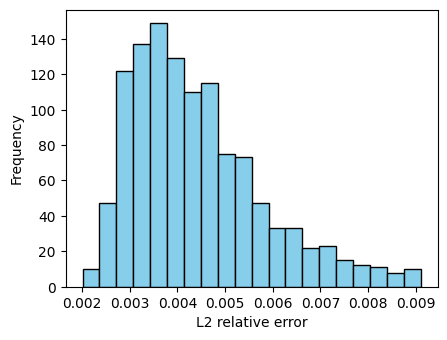

In [40]:
# overall performance on all test samples
error_s = cal_l2_error(s_pred_test, s_true_test)
sort_idx = np.argsort(error_s)
mean, std = np.mean(error_s), np.std(error_s)
print(f"Mean L2 error of test dataset: {mean}, std: {std}")
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)
_ = ax.hist(error_s[sort_idx[:-20]], bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")



L2 realtive error of the best test sample: 0.0020070394966751337


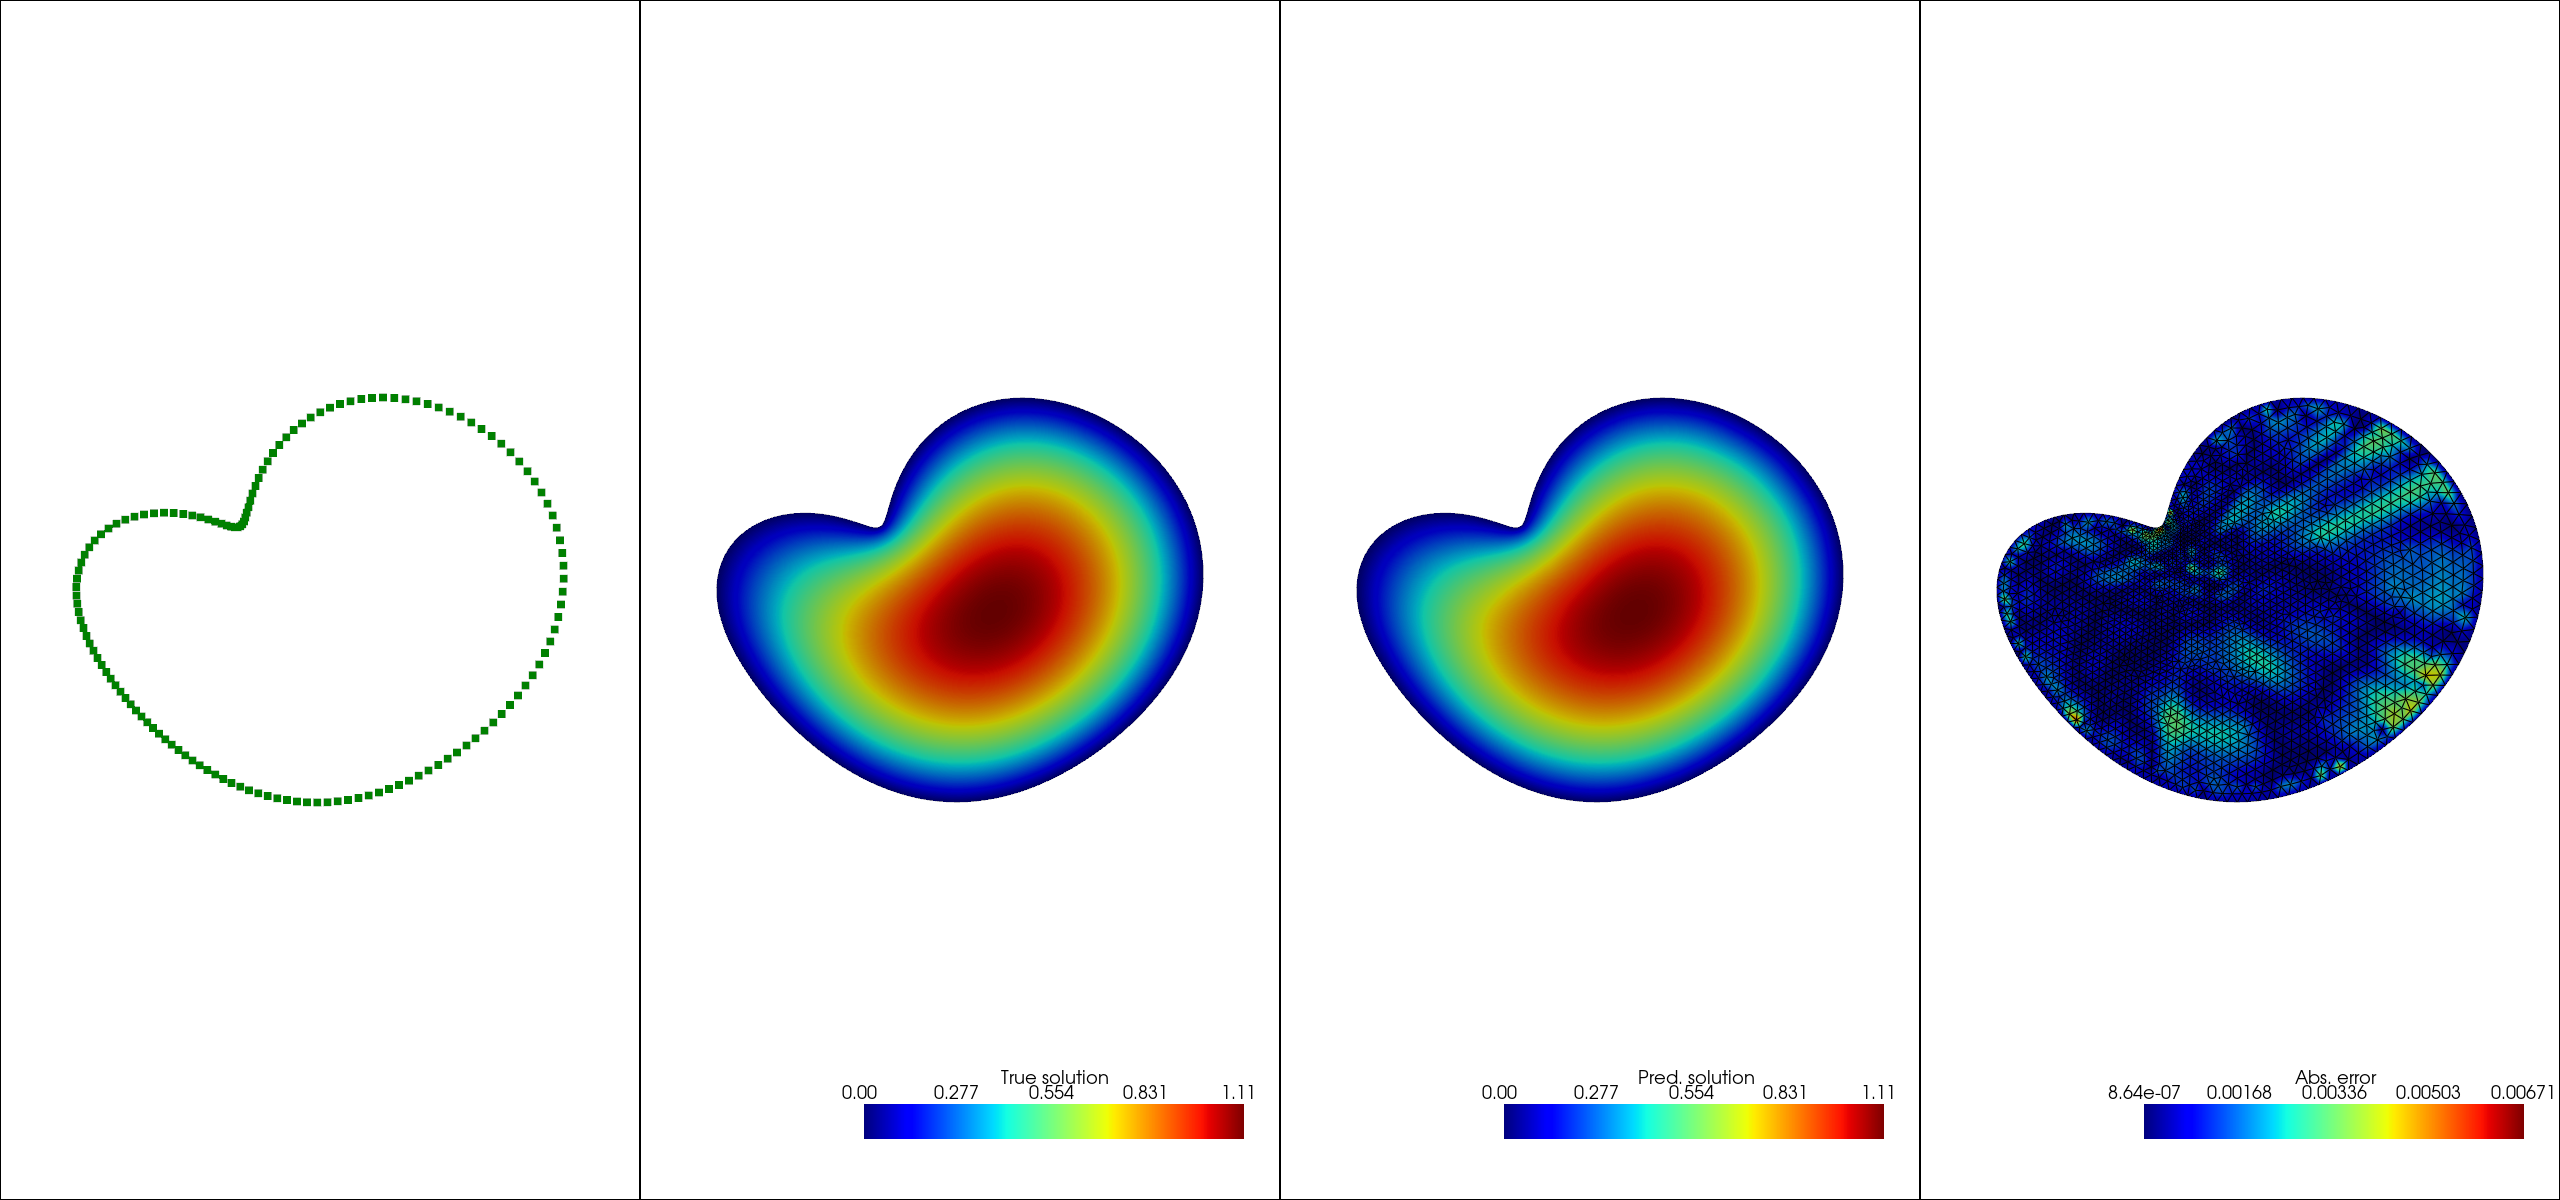

In [41]:
# plot the best sample
index = sort_idx[0]
print(
    f"L2 realtive error of the best test sample: {error_s[index]}")
cells_test = cells_all[sample_ids_test[index]]
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
pc_no_padded = surface_pc_test.numpy()
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]
plot_results(pc_no_padded, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True, html_file=None,show_edges=False, window_size=window_size)



L2 realtive error of the 50 percentile test sample: 0.0041480474174022675


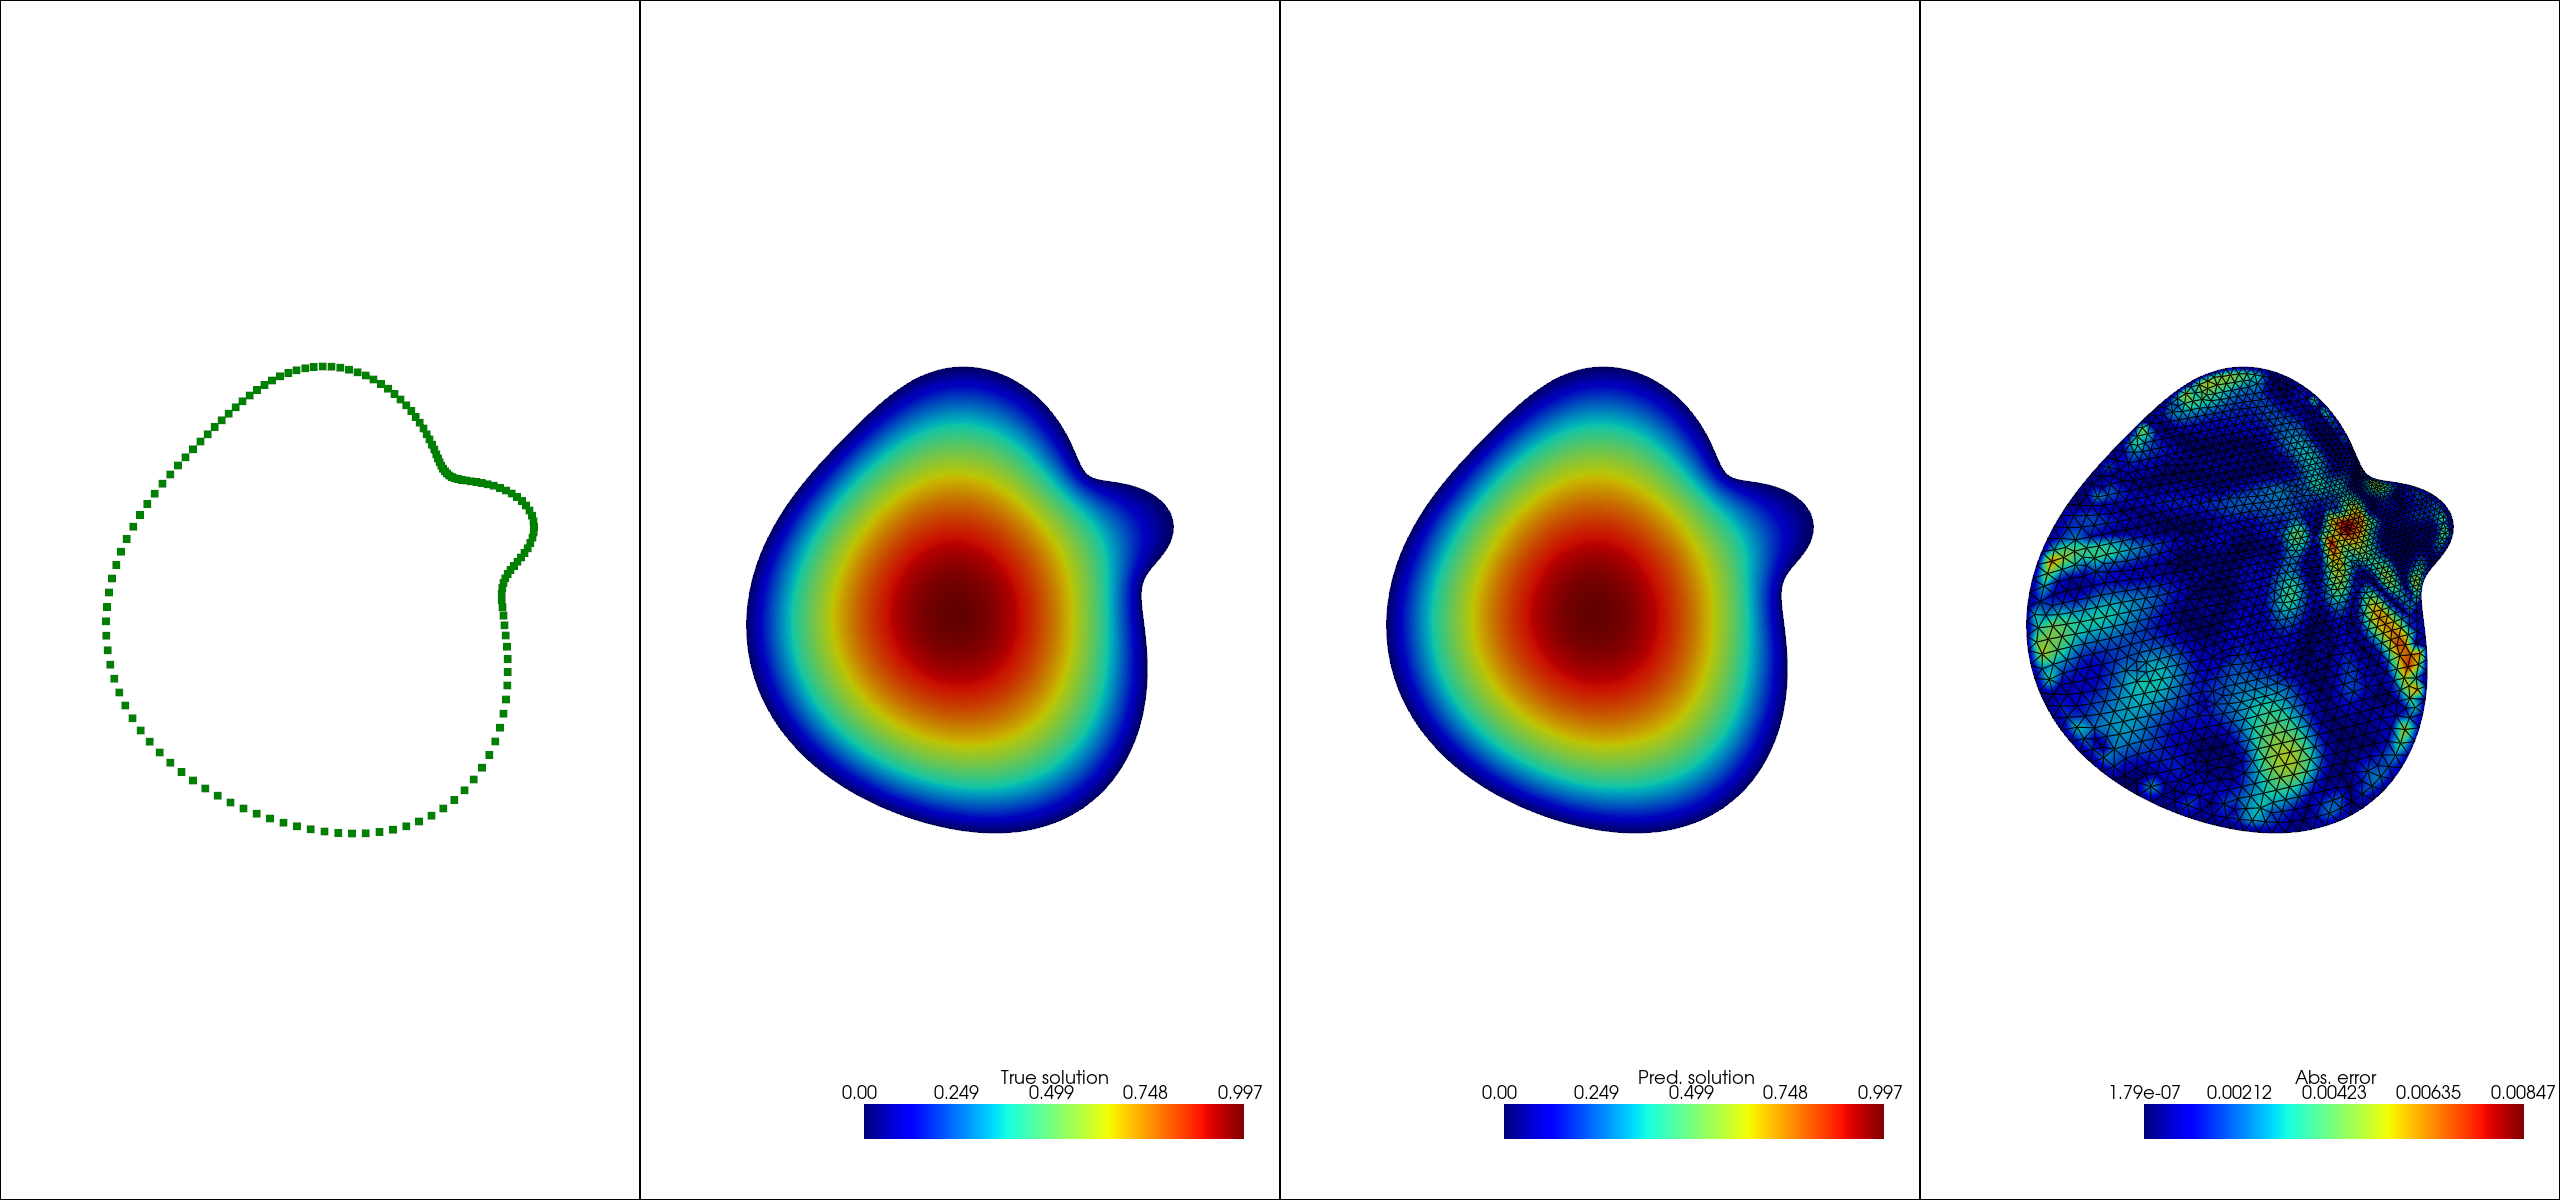

In [42]:
# plot the median sample
index = sort_idx[int(len(sort_idx)*0.5)-2]
print(
    f"L2 realtive error of the 50 percentile test sample: {error_s[index]}")
cells_test = cells_all[sample_ids_test[index]]
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
pc_no_padded = surface_pc_test.numpy()
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]
plot_results(pc_no_padded, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True, html_file=None,show_edges=False, window_size=window_size)



L2 realtive error of the worst test sample: 0.022759217768907547


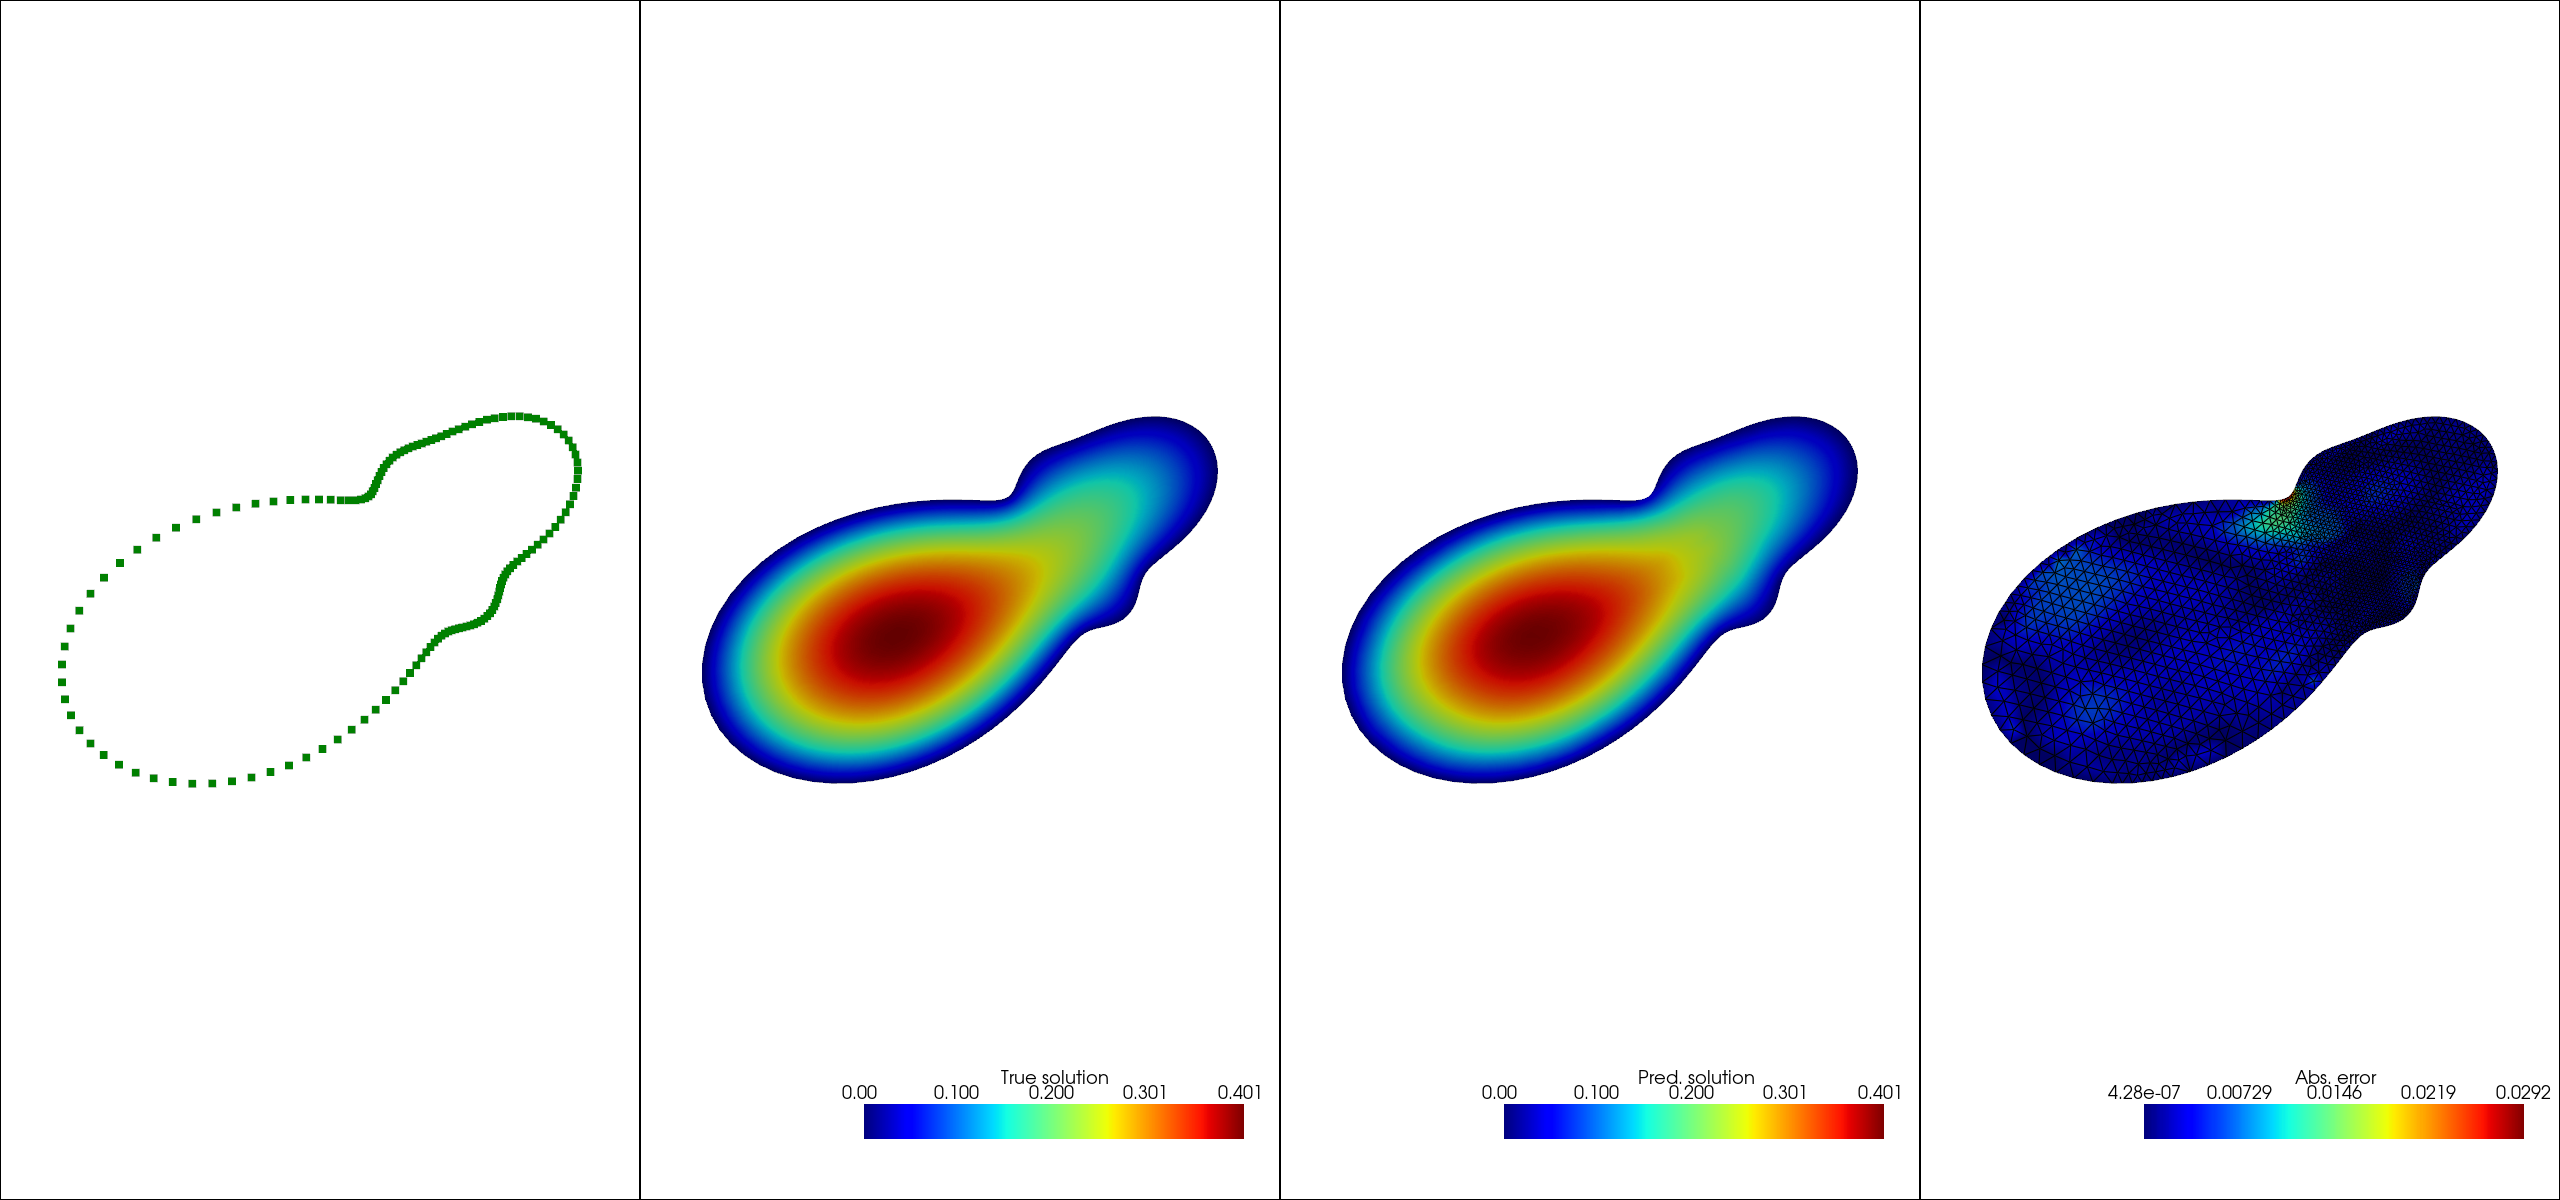

In [43]:
# plot the worst sample
index = sort_idx[int(len(sort_idx))-1]
print(
    f"L2 realtive error of the worst test sample: {error_s[index]}")
cells_test = cells_all[sample_ids_test[index]]
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
pc_no_padded = surface_pc_test.numpy()
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]
plot_results(pc_no_padded, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True, html_file=None,show_edges=False, window_size=window_size)



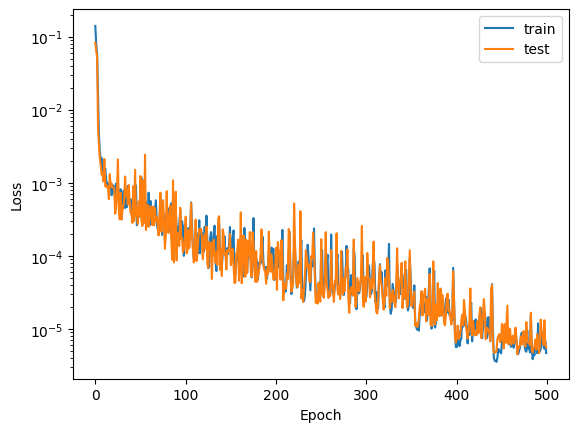

In [44]:
loss_file = filebase + "/logs.json"
with open(loss_file, 'r') as f:
    data = json.load(f)
plt.plot(data['loss'], label='train')
plt.plot(data['val_loss'], label='test')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



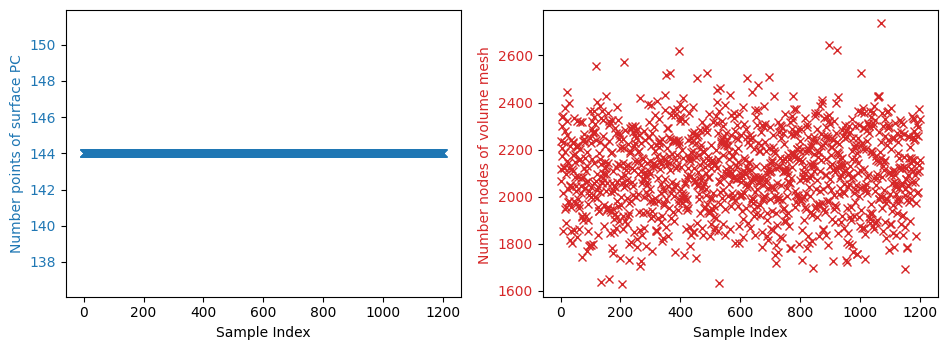

In [45]:
num_pc_point = [x.shape[0] for x in pc_all_test]
num_query_points = [len(x) for x in verts_all_test]
fig = plt.figure(figsize=(4.8*2, 3.6))
ax1 = plt.subplot(1, 2, 1)
color = 'tab:blue'
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Number points of surface PC', color=color)
ax1.plot(num_pc_point, 'x', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = plt.subplot(1, 2, 2)
color = 'tab:red'
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Number nodes of volume mesh ', color=color)
ax2.plot(num_query_points, 'x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
